Things to cover in this section:

✔️ Train, tune and use time series, sequence and prediction models.  
✔️ Prepare data for time series learning.  
✔️ Understand Mean Average Error (MAE) and how it can be used to evaluate accuracy of sequence models.  
  Use RNNs and CNNs for time series, sequence and forecasting models.  
✔️ Identify when to use trailing versus centred windows.  
  Use TensorFlow for forecasting.  
✔️ Prepare features and labels.  
  Identify and compensate for sequence bias.  
  Adjust the learning rate dynamically in time series, sequence and prediction models.  

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import datetime

import tensorflow as tf

## 

In [3]:
sunspot = pd.read_csv('../datasets/sunspot.csv')
series = np.array(sunspot.x.to_list())

In [4]:
date_str = '1749-01-01' # Start date
format_str = '%Y-%m-%d' # The format
start_date = datetime.datetime.strptime(date_str, format_str)

In [5]:
dates = [start_date+relativedelta(months=+i) for i in range(3177)]

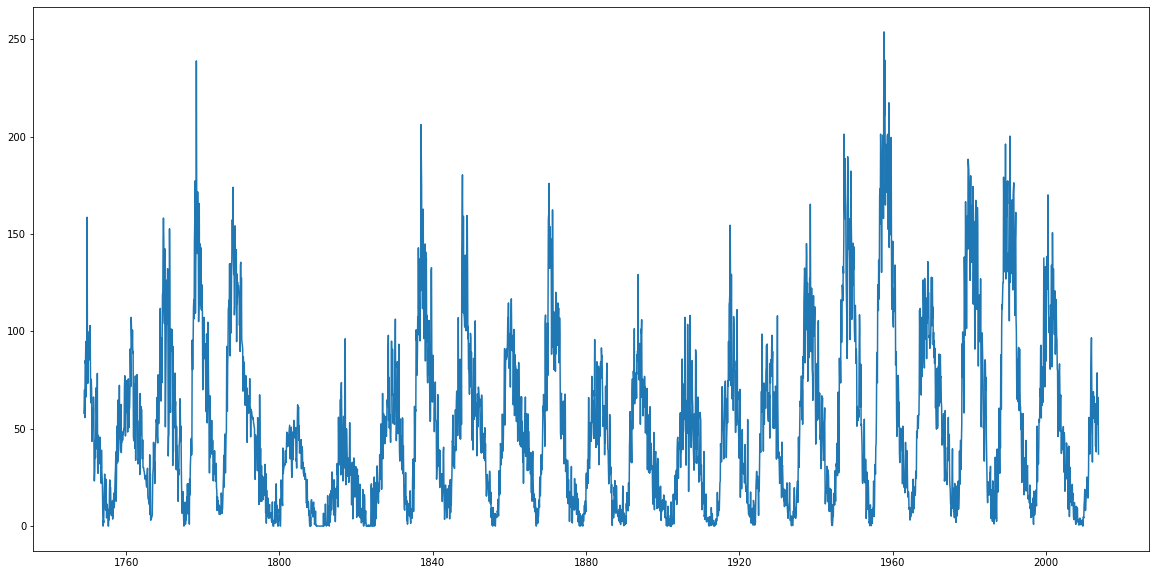

In [6]:
plt.figure(figsize=(20,10))
plt.plot(dates, series)

## Prepare features and labels.  

In [7]:
dataset = tf.data.Dataset.range(12)

dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

In [8]:
for x, y in dataset:
    print('x = ', x.numpy())
    print('y = ', y.numpy())

x =  [[ 7  8  9 10]
 [ 0  1  2  3]]
y =  [[11]
 [ 4]]
x =  [[1 2 3 4]
 [2 3 4 5]]
y =  [[5]
 [6]]
x =  [[4 5 6 7]
 [3 4 5 6]]
y =  [[8]
 [7]]
x =  [[5 6 7 8]
 [6 7 8 9]]
y =  [[ 9]
 [10]]


# Single Layer Network
This will be like a simple linear regression.

In [36]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

In [64]:
window_size = 60
batch_size = 2
split_time = 1000
shuffle_buffer_size=10

In [38]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

In [39]:
model = tf.keras.models.Sequential([l0])

In [40]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [41]:
model.fit(dataset, epochs=10, verbose=0)

In [43]:
l0.get_weights()

[array([[ 0.35438585],
        [ 3.3302953 ],
        [ 5.005951  ],
        [ 1.3076422 ],
        [ 2.441944  ],
        [ 1.8178877 ],
        [-2.9027576 ],
        [-1.8600582 ],
        [ 2.8929474 ],
        [ 0.64135915],
        [ 1.7763622 ],
        [-0.40279958],
        [-1.9016609 ],
        [-2.6079426 ],
        [-3.1322734 ],
        [-2.4470754 ],
        [ 0.20909655],
        [-0.7679014 ],
        [ 0.8521578 ],
        [-1.0643514 ],
        [ 1.899173  ],
        [ 0.99900097],
        [ 0.6335705 ],
        [-1.1573744 ],
        [-1.5474826 ],
        [-0.5258618 ],
        [ 0.36265156],
        [-0.41420162],
        [ 2.5480216 ],
        [-0.3636983 ],
        [-1.0131252 ],
        [ 2.3471653 ],
        [ 2.1391387 ],
        [ 0.80043244],
        [ 2.0850127 ],
        [ 1.1978439 ],
        [-0.669365  ],
        [-0.40322387],
        [-1.8701258 ],
        [ 1.4637215 ],
        [ 1.4360688 ],
        [-1.6034805 ],
        [ 0.97779226],
        [ 2

In [49]:
model.predict(series[0:window_size][np.newaxis])

array([[420.573]], dtype=float32)

In [50]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [58]:
forecasted = [i[0][0] for i in forecast]

In [65]:
forecasted = forecasted[split_time-window_size:]

In [66]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [69]:
len(forecasted)

2177

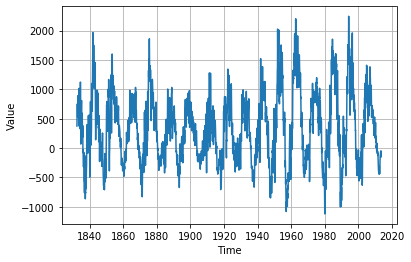

In [77]:
plot_series(dates[split_time:], forecasted)

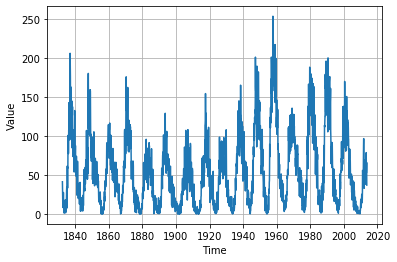

In [78]:
plot_series(dates[split_time:], series[split_time:])

## Understand Mean Average Error (MAE) and how it can be used to evaluate accuracy of sequence models.  

In [88]:
x_valid = series[split_time:]
results = forecasted


tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

544.7079